# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [5]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [6]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [7]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [8]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [9]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [11]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [12]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
  - For Age imputation with mean and median gave pretty similar results, the only difference being the increase in frequency for the mean/median value. But I thing using median is better for age, as if we use mean, it could give rise to ages that don't even exist in the dataset

2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?
  - It adds 2 new values to the value_counts result, that being "Unknown".

  

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64


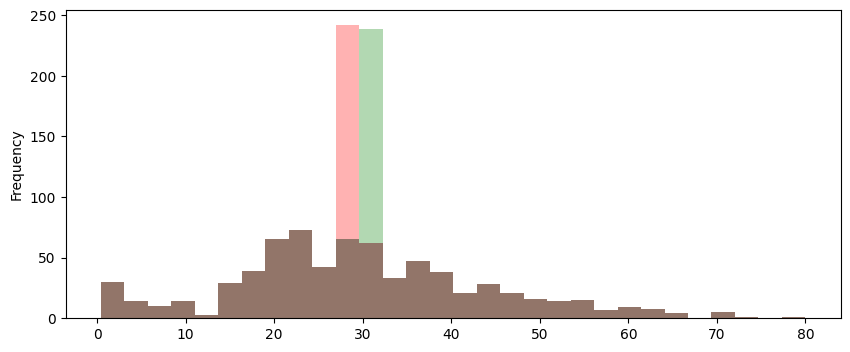

In [13]:
# 1)
dfc = df.copy()

plt.figure(figsize=(10,4))
age_distribution = dfc['Age'].plot(kind='hist', bins=30, alpha=0.5, label='Original')
age_mean_distribution = (dfc.copy()['Age'].fillna(dfc['Age'].mean())).plot(kind='hist', bins=30, color='green', alpha=0.3, label='Mean Imputed')
age_median_distribution = dfc.copy()['Age'].fillna(dfc['Age'].median()).plot(kind='hist', bins=30, color='red', alpha=0.3, label='Median Imputed')



# 2)

print(df['Embarked'].value_counts())
print(dfc['Embarked'].fillna("Unknown").value_counts())


## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

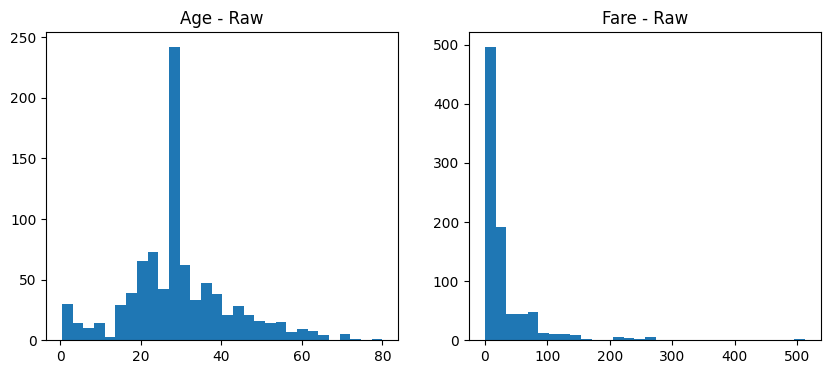

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

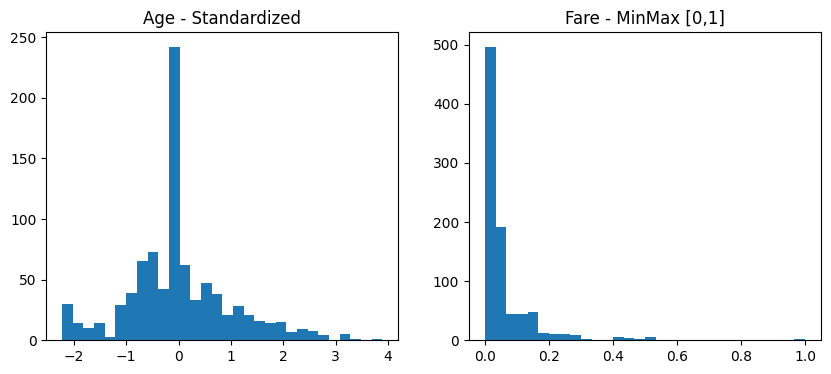

In [15]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
  - Run the below cell.
  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

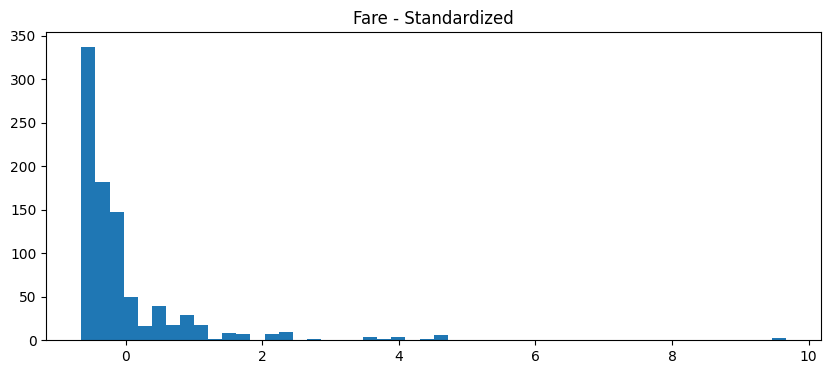

   Age_norm  Fare_norm
0  0.949757   0.312988
1  0.470417   0.882444
2  0.956551   0.291564
3  0.550338   0.834942
4  0.974555   0.224148


In [17]:
fare_std = sc_std.fit_transform(df_imp[['Fare']])

plt.figure(figsize=(10,4))
plt.hist(fare_std.flatten(), bins=50)
plt.title('Fare - Standardized')
plt.show()


norm = Normalizer()

x_norm = norm.fit_transform(df_imp[['Age', 'Fare']])

# Put back into a DataFrame for readability
X_norm_df = pd.DataFrame(x_norm, columns=['Age_norm', 'Fare_norm'])

# Show first 5 normalized rows
print(X_norm_df.head())


## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [18]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [19]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
  - for 'Embarked', in the ordinal form there is only one feature, but with one-hot method there are 2 as there are 3 types here

2) Why might one-hot be safer for linear models?
  - ordinal encoding might introduce order to feature that don't have any order, this might skew the data. one-hot encoding gives a nominal encoding
  

## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

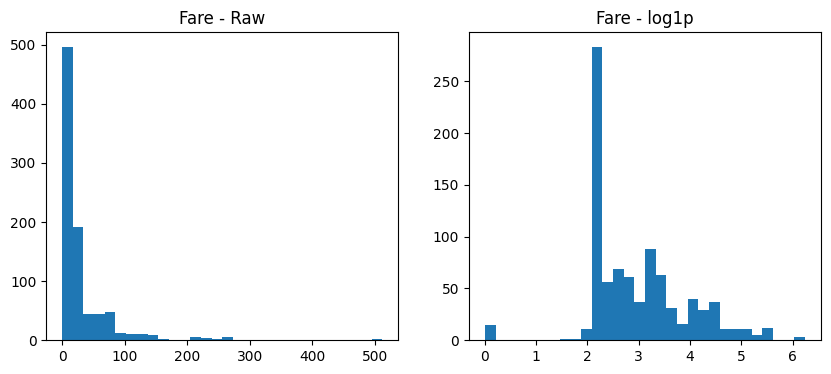

In [20]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

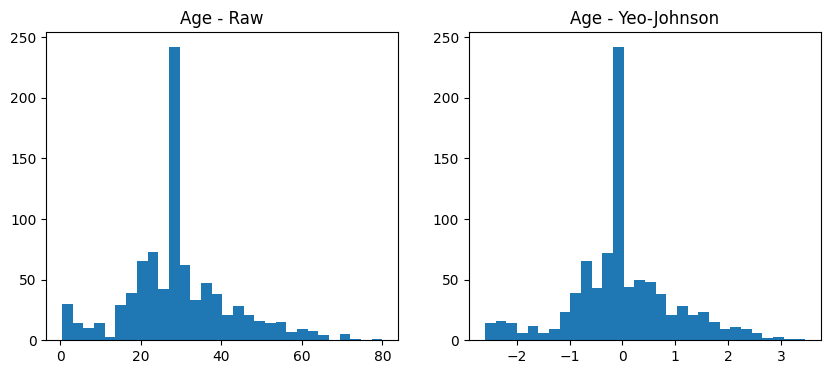

In [16]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [17]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?
  -  [ 1,   Age^2,   Age Fare,  Fare^2 ] these are the new terms created.
  

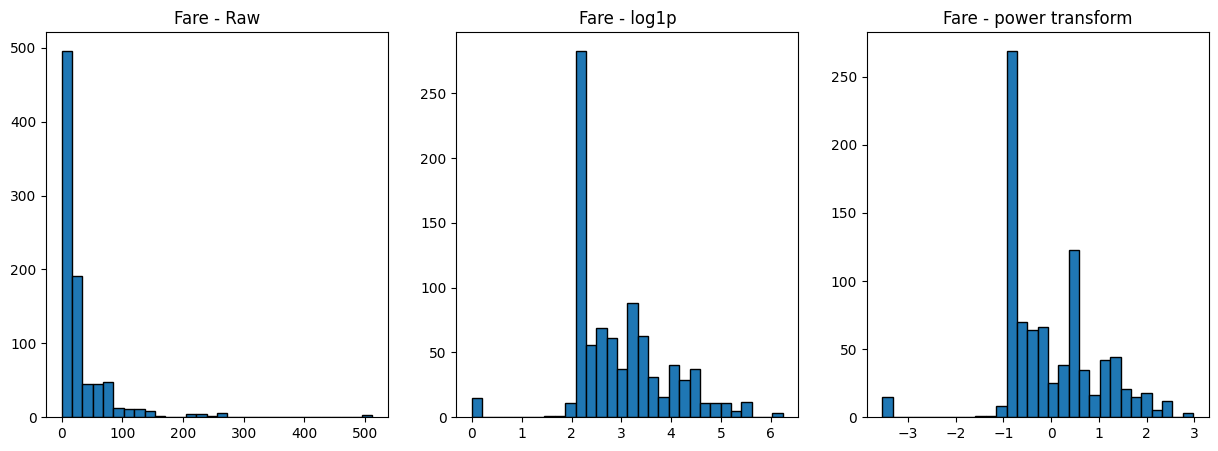


Expanded features from Age and Fare (degree=2):
     1   Age     Fare   Age^2   Age Fare       Fare^2
0  1.0  22.0   7.2500   484.0   159.5000    52.562500
1  1.0  38.0  71.2833  1444.0  2708.7654  5081.308859
2  1.0  26.0   7.9250   676.0   206.0500    62.805625
3  1.0  35.0  53.1000  1225.0  1858.5000  2819.610000
4  1.0  35.0   8.0500  1225.0   281.7500    64.802500


In [38]:
import matplotlib.pyplot as plt

fare_check = df_imp.copy()["Fare"].dropna()
fare_check_log = np.log1p(fare_check)
pwt = PowerTransformer()
fare_check_pt = pwt.fit_transform(fare_check.values.reshape(-1,1))

fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].hist(fare_check, bins=30, edgecolor='k')
axes[0].set_title('Fare - Raw')

axes[1].hist(fare_check_log, bins=30, edgecolor='k')
axes[1].set_title('Fare - log1p')

axes[2].hist(fare_check_pt.ravel(), bins=30, edgecolor='k')  # <-- flatten needed
axes[2].set_title('Fare - power transform')

plt.show()


# 2)

X = df[['Age','Fare']].dropna()

poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X)

poly_features = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(['Age','Fare']))

print("\nExpanded features from Age and Fare (degree=2):")
print(poly_features.head())



## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96165195 0.03587775]


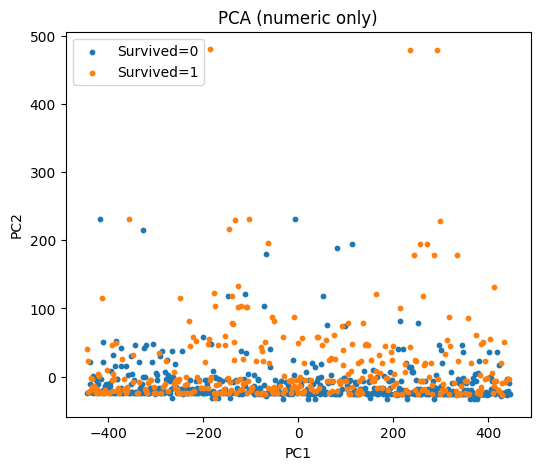

In [39]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [50]:
num_df = df.select_dtypes(include=['float64','int64'])

# Variance of each numeric column
variances = num_df.var().sort_values(ascending=False)
print("Column variances:\n", variances.head(2))

# 2)

num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=3, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

Column variances:
 PassengerId    66231.000000
Fare            2469.436846
dtype: float64
Explained variance ratios: [0.96165195 0.03587775 0.0024362 ]
Cumulative explained variance: [0.96165195 0.9975297  0.9999659 ]


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
    - Fare was highly right skewed but with log transformsation it was make much closer to normal.
- Which encoding produced **more features**, ordinal or one-hot? Why?
    - one-hot produced more features, as it creates new features for each category that exists.
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)


URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("df Shape:", df.shape)

df_imp = df.copy()
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')


std = StandardScaler()
min_max = MinMaxScaler()

age_std = std.fit_transform(df_imp[['Age']])
fare_mm = min_max.fit_transform(df_imp[['Fare']])
df_imp['Age'] = age_std.flatten()
df_imp['Fare'] = fare_mm.flatten()

df_imp = pd.get_dummies(df_imp, columns=['Sex','Embarked'], drop_first=False)
df_imp['Fare'] = np.log1p(df_imp['Fare'])

print(df_imp.head())



num_df = df_imp.select_dtypes(include=[np.number]).dropna(axis=1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(num_df)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.cumsum())


df Shape: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name       Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris -0.565736      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  0.663861      1      0   
2                             Heikkinen, Miss. Laina -0.258337      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  0.433312      1      0   
4                           Allen, Mr. William Henry  0.433312      0      0   

             Ticket      Fare    Cabin  Sex_female  Sex_male  Embarked_C  \
0         A/5 21171  0.014052  Unknown       False      True       False   
1          PC 17599  0.130270      C85        True     False        True   
2  STON/O2. 3101282  0.015350  Unknown        True    

## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).